In [69]:
#Loading the libraries
import tensorflow as tf

import numpy as np
import pandas as pd
from  IPython import display
from matplotlib import pyplot as plot

import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
import re

#important libraries for preprocessing using NLTK
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from collections import Counter

!pip install tweet-preprocessor
import preprocessor as p

#I dont think we need this
!python -m pip install -U gensim
from gensim.parsing.preprocessing import remove_stopwords

#We dont need this library for now
#installing ekphrasis
!pip install ekphrasis

# Segmenter used for sengmenting the hashtags
from ekphrasis.classes.segmenter import Segmenter
#segmenter using the word statistics from Twitter
seg = Segmenter(corpus="twitter")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)
Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp "/content/drive/My Drive/Data/glove.6B.100d.txt" "glove"

In [70]:
#To Preprocess using the functions from tweet-processor package
def preprocess_tweet(row):
    text = row['Tweet']
    text = p.clean(text)
    return text

In [71]:
#Using WordNet Lemmatizer
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()
word_tokenizer = TweetTokenizer()
#Lemmatize_text function lemmatizes the words
def lemmatize_text(text):
     return [(lemmatizer.lemmatize(w)) for w in \
                                     word_tokenizer.tokenize((text))]

In [72]:
#Convert list to string function
def convert_list_to_string(original_list, separator=' '):
    return separator.join(original_list)

In [73]:
#Loading the file
pd.set_option('max_colwidth',150)
filename = "train.csv"
tweets_df = pd.read_csv(filename,index_col=None, header=0, engine='python')

In [74]:
#Checking the contents of the datafile
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,Hillary Clinton,FAVOR,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
4,@PortiaABoulger Thank you for adding me to your list,Hillary Clinton,NONE,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos
5,Hillary can not win. Here's hoping the Dems offer a real candidate like Warren. #Warren2016,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
6,"Respect FOR the law and respect BY the law Yes, needed desperately. #BaltimoreRiots",Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,pos
7,I don't want to be appointed to an Ambassador post.,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg
8,"#StopHillary2016 @HillaryClinton if there was a woman with integrity and honesty I would vote for such as woman president, NO",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
9,@HillaryClinton End lawless #ClintonFoundation. Jail Butcher of #Benghazi. #Arrest rapist #BillClinton. #HillaryClinton,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg


In [75]:
#Checking the tweet text content
print(tweets_df['Tweet'][0])

@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot


In [76]:
#Checking the values in Target Column
tweets_df['Target'].value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

In [77]:
#Checking the values in Sentiment Column
tweets_df['Sentiment'].value_counts()

neg      1762
pos       963
other     189
Name: Sentiment, dtype: int64

In [78]:
#Checking the values in Stance Column
tweets_df['Stance'].value_counts()

AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64

In [79]:
#Checking the values grouped by Target and Stance
tweets_df.groupby(['Target','Stance']).size()

Target                            Stance 
Atheism                           AGAINST    304
                                  FAVOR       92
                                  NONE       117
Climate Change is a Real Concern  AGAINST     15
                                  FAVOR      212
                                  NONE       168
Feminist Movement                 AGAINST    328
                                  FAVOR      210
                                  NONE       126
Hillary Clinton                   AGAINST    393
                                  FAVOR      118
                                  NONE       178
Legalization of Abortion          AGAINST    355
                                  FAVOR      121
                                  NONE       177
dtype: int64

In [80]:
#Hastag and Mentions Preprocessing

tweets_df["mention"] = tweets_df["Tweet"].apply(lambda x: re.findall(r"@(\w+)", x))
tweets_df["hashtag"] = tweets_df["Tweet"].apply(lambda x: re.findall(r"#(\w+)", x))
tweets_df['hashtag_string'] = tweets_df['hashtag'].apply(convert_list_to_string)

#Segmenting the hashtags
for i in range(tweets_df.shape[0]):
    tweets_df["hashtag_string"][i] = seg.segment(tweets_df["hashtag_string"][i])
    
#Appending Hashtags to the Tweet Text
for i in range(tweets_df.shape[0]):
    tweets_df["Tweet"][i] = tweets_df["Tweet"][i] + " " + tweets_df["hashtag_string"][i]

#Appending target to the Tweet Text
for i in range(tweets_df.shape[0]):
    tweets_df["Tweet"][i] = tweets_df["Target"][i] + " " + tweets_df["Tweet"][i]

tweets_df.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment,mention,hashtag,hashtag_string
0,"Hillary Clinton @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot ha...",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[tedcruz],"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot
1,Hillary Clinton Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio ohio,Hillary Clinton,FAVOR,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos,[],[Ohio],ohio
2,"Hillary Clinton @TheView I think our country is ready for a female pres, it can't ever be Hillary",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[TheView],[],
3,Hillary Clinton I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary why i...,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[],[WhyImNotVotingForHillary],why im not voting for hillary
4,Hillary Clinton @PortiaABoulger Thank you for adding me to your list,Hillary Clinton,NONE,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos,[PortiaABoulger],[],


In [81]:
#Clean the mentions and hashtags,urls and mentions from the tweet text using preprocess function 
#from tweet-preprocessor
tweets_df['Tweet'] = tweets_df.apply(preprocess_tweet, axis = 1)

#Convert the text to lower text and remove punctuations
tweets_df['Tweet'] = tweets_df['Tweet'].str.lower().str.replace('[^\w\s]','').str.replace('\s\s+', '')

#Remove Digits from the Tweet
tweets_df['Tweet'] = tweets_df['Tweet'].str.replace('\d+', '')

#Lemmatize and tokenize text
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lemmatize_text)


tweets_df["Tweet"] = tweets_df["Tweet"].apply(lambda x: [word.replace('semst','') for word in x])
tweets_df["Tweet"] = tweets_df["Tweet"].apply(lambda x: [word.replace('sem st','') for word in x])
tweets_df["Tweet"] = tweets_df["Tweet"].apply(lambda x: [word.replace('sem','') for word in x])
tweets_df["Tweet"] = tweets_df["Tweet"].apply(lambda x: [word.replace('st','') for word in x])

#Last step is to remove the stop words from the lemmatized and tokenized words lists
stop_words = set(stopwords.words('english'))
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lambda x: [item for item in \
                                                         x if item not in stop_words])

tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,mention,hashtag,hashtag_string
0,"[hillary, clinton, wiped, cleank, deleted, email, explains, dereliction, dutylies, etc, hand, server, benghazi, tcot]",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[tedcruz],"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot
1,"[hillary, clinton, hillary, choice, truly, want, continue, progressive, nation, ohio]",Hillary Clinton,FAVOR,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos,[],[Ohio],ohio
2,"[hillary, clinton, think, country, ready, female, pres, cant, ever, hillary]",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[TheView],[],
3,"[hillary, clinton, ju, gave, unhealthy, amount, hardearned, money, away, big, govtuntruworthy, irs, im, voting, hillary]",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[],[WhyImNotVotingForHillary],why im not voting for hillary
4,"[hillary, clinton, thank, adding, li]",Hillary Clinton,NONE,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos,[PortiaABoulger],[],
5,"[hillary, clinton, hillary, win, hoping, dems, offer, real, candidate, like, warren, warren]",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[],[Warren2016],warren 2016
6,"[hillary, clinton, respect, law, respect, law, yes, needed, desperately, baltimore, riot]",Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,pos,[],[BaltimoreRiots],baltimore riots
7,"[hillary, clinton, dont, want, appointed, ambassador, po]",Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg,[],[],
8,"[hillary, clinton, wa, woman, integrity, honey, would, vote, woman, president, op, hillary]",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[HillaryClinton],[StopHillary2016],stop hillary 2016
9,"[hillary, clinton, end, lawlessjail, butcher, ofrapiclinton, foundation, benghazi, arre, bill, clinton, hillary, clinton]",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg,[HillaryClinton],"[ClintonFoundation, Benghazi, Arrest, BillClinton, HillaryClinton]",clinton foundation benghazi arrest bill clinton hillary clinton


In [82]:
tweets_df['Target'].unique()

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement'],
      dtype=object)

In [83]:
!pip install wordcloud


 Generating Word Cloud for Hillary Clinton 



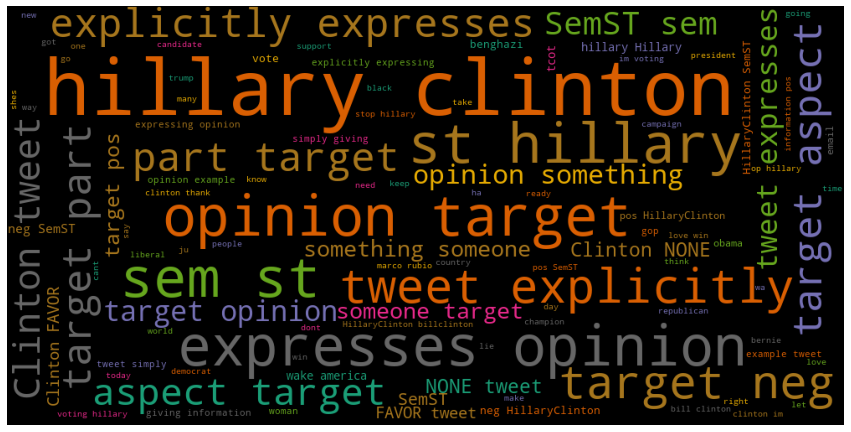


 Generating Word Cloud for Legalization of Abortion 



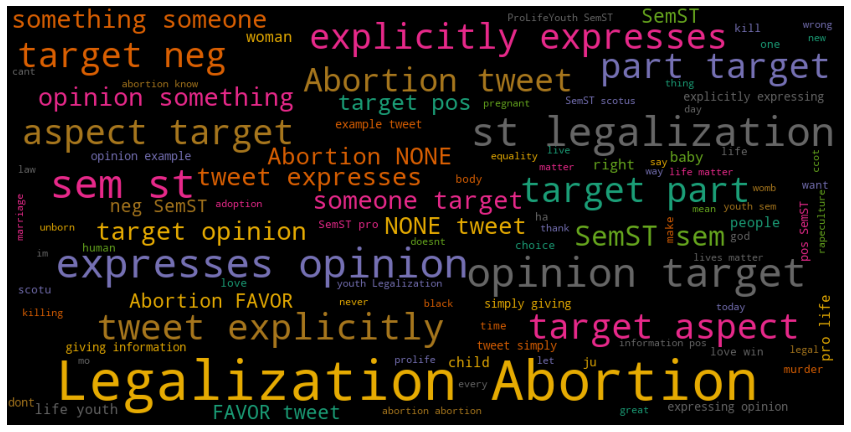


 Generating Word Cloud for Atheism 



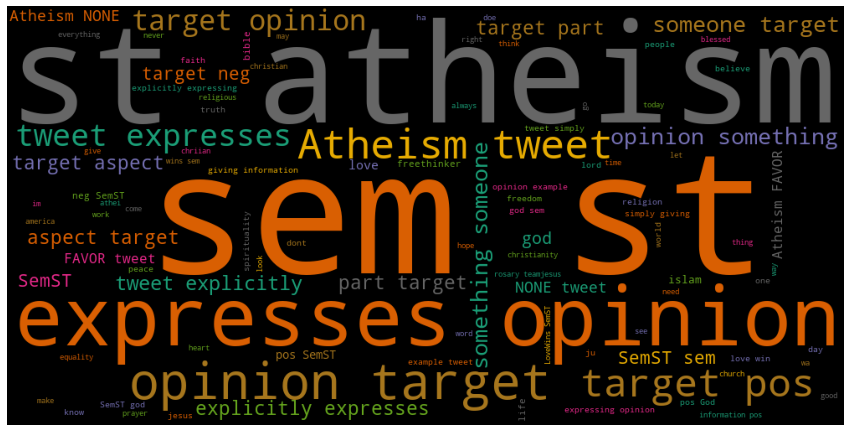


 Generating Word Cloud for Climate Change is a Real Concern 



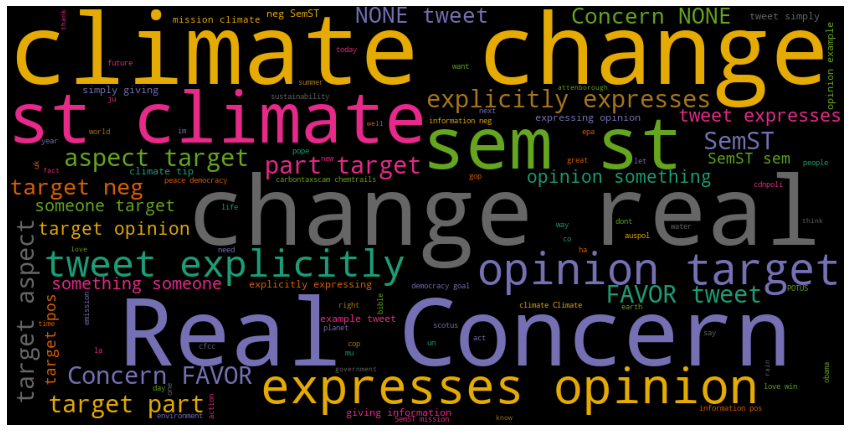


 Generating Word Cloud for Feminist Movement 



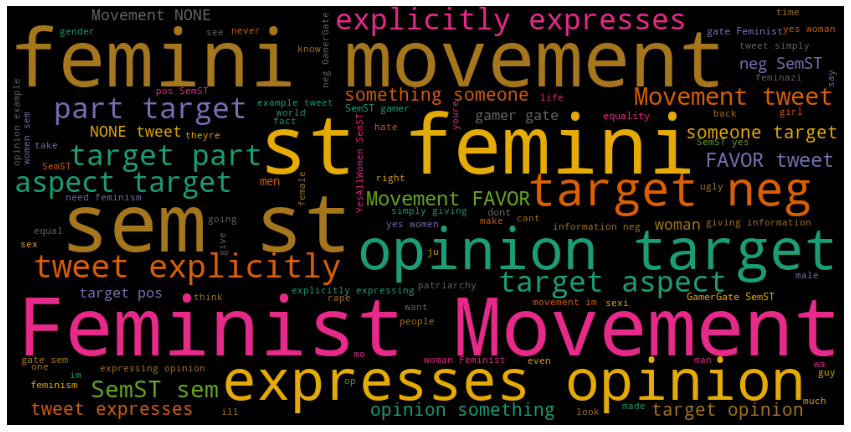

In [84]:
#For loop for generating word cloud for each target variable
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

target_list = ['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement']



for target in target_list:
    wordcloud = WordCloud(width = 1000, height = 500,max_words=100, colormap="Dark2")
    print("\n Generating Word Cloud for {} \n".format(target))
    wordcloud.generate(tweets_df[tweets_df.iloc[:,1] == target].to_string())
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

In [85]:
tweets_df.shape

(2914, 8)

In [86]:
#Converting the strings to tweets
tweets_df['Tweet'] = tweets_df['Tweet'].apply(convert_list_to_string)

In [87]:
#Converting the texts and stance to numpy array
texts = np.array(tweets_df['Tweet'][:2914])
stance_labels = np.array(tweets_df['Stance'][:2914])

In [88]:
#Checking the Shape of the text and stance labels
print("Shape of Text: "+str(texts.shape))
print("Shape of Stance Labels: "+str(stance_labels.shape))

Shape of Text: (2914,)
Shape of Stance Labels: (2914,)


In [89]:
#Checking the counter labels
Counter(stance_labels)

Counter({'AGAINST': 1395, 'FAVOR': 753, 'NONE': 766})

In [90]:
from keras.utils.np_utils import to_categorical #Experimenting

In [91]:
#Tokenizing the words for 
from keras.preprocessing.text import Tokenizer
# SOME MACROS That we need to tune later
MAX_SEQ_LENGTH = 200
MAX_WORDS = 20000
EMBEDDING_DIMENSION = 100

#The all the texts
all_text = []
for i in range(texts.shape[0]):
    all_text.append(texts[i])


In [92]:
#Truncating the words based on the maximum number of words allowed
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(all_text)
#Integer Encoding 
sequences = tokenizer.texts_to_sequences(all_text)
word_index = tokenizer.word_index

In [93]:
#Padding the sequences so that all the texts are of the same lengh
from keras.preprocessing.sequence import pad_sequences
input_data_tensor = pad_sequences(sequences,maxlen= MAX_SEQ_LENGTH )

In [94]:
#Checking the contents of the train data
print(input_data_tensor)

[[   0    0    0 ...  754  181   78]
 [   0    0    0 ...  647  182 1305]
 [   0    0    0 ...   45  125    1]
 ...
 [   0    0    0 ... 1067  159 1482]
 [   0    0    0 ...  377 1482   13]
 [   0    0    0 ... 1285 1722  374]]


In [95]:
#Shape of the matrix
print("Shape of Train Data:"+ str(input_data_tensor.shape))

Shape of Train Data:(2914, 200)


In [96]:
#Integer Encoding the stance labels
encoded_stance_labels = []
for stance_label in stance_labels:
    if stance_label == "AGAINST":
        encoded_stance_labels.append(0)
    elif stance_label == "FAVOR":
        encoded_stance_labels.append(1)
    else:
        encoded_stance_labels.append(2)
# Temporary Change
labels = encoded_stance_labels
labels = np.array(labels)
labels

array([0, 1, 0, ..., 0, 0, 0])

In [97]:
# #Uncomment to see the Integer coded stance labels
#print(encoded_stance_labels)
# labels = encoded_stance_labels

In [98]:
#shuffling the dataframe
shuffled_index = np.arange(input_data_tensor.shape[0])
np.random.shuffle(shuffled_index)
input_data_tensor = input_data_tensor[shuffled_index]
labels = labels[shuffled_index]

n_values = np.max(labels)+1
labels = np.eye(n_values)[labels]

In [99]:
print("Data Tensor:"+str(input_data_tensor))
print("Label Tensor:"+str(labels))
print("Shape of Data Tensor:"+str(input_data_tensor.shape))
print("Shape of Labels Tensor:"+str(labels.shape))

Data Tensor:[[   0    0    0 ... 1004 6229  281]
 [   0    0    0 ...   27  265  564]
 [   0    0    0 ...  231  100   31]
 ...
 [   0    0    0 ... 1498   12  320]
 [   0    0    0 ...   24  227  246]
 [   0    0    0 ... 1082  772  342]]
Label Tensor:[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
Shape of Data Tensor:(2914, 200)
Shape of Labels Tensor:(2914, 3)


__Train, Validation and Test Split__

In [100]:
validation_split = 0.20

num_validation_samples = int(validation_split * input_data_tensor.shape[0])

X_train = input_data_tensor[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val = input_data_tensor[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [101]:
print("X_train shape: " + str(X_train.shape))
print("X_val shape: " + str(y_train.shape))
print("y_train shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

X_train shape: (2332, 200)
X_val shape: (2332, 3)
y_train shape: (582, 200)
y_val shape: (582, 3)


Function to plot the model results

In [102]:
from itertools import cycle
def plotter(history_hold, metric = 'CategoricalCrossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

BASIC LSTM MODEL

In [103]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential

embedding_dim = 100
max_length = 200

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=max_length,
                            trainable=True)

model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_glove.add(Dense(3, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model_glove.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          754400    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 771,523
Trainable params: 771,523
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
# EPOCH = 20
# m_histories = {}
# m_histories['no_TL'] = model_glove.fit(X_train, y_train, batch_size=32, 
#                                        epochs=EPOCH, validation_data=(X_val, y_val), verbose=1)

In [105]:

# #Plot the model loss metric
# plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')
# #Plot the model Accuracy metric
# plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

2 Layer Bidirectional LSTM

In [106]:
# from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
# from tensorflow.keras.models import Sequential

# embedding_dim = 100
# max_length = 200

# embedding_layer = Embedding(len(word_index) + 1,
#                             embedding_dim,
#                             input_length=max_length,
#                             trainable=True)

# model2 = Sequential()
# model2.add(embedding_layer)
# model2.add(Bidirectional(LSTM(units=32, dropout=0.5, recurrent_dropout=0.25,return_sequences=True))),
# model2.add(Bidirectional(LSTM(units=32, dropout=0.5, recurrent_dropout=0.25,return_sequences=False))),
# model2.add(Dense(64,activation = "relu")),
# model2.add(Dense(3, activation='softmax'))

# model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

# print(model2.summary())

In [107]:
# EPOCH = 20
# m_histories = {}
# m_histories['model2'] = model2.fit(X_train, y_train, batch_size=32, 
#                                        epochs=EPOCH, validation_data=(X_val, y_val), verbose=1)

BASIC LSTM WITH TRANSFER LEARNING

In [108]:
file = open('glove', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

In [109]:
E_T = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        E_T[i] = embedding_vector

In [110]:
# from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
# from tensorflow.keras.models import Sequential

# embedding_dim = 100
# max_length = 200

# embedding_layer = Embedding(len(word_index) + 1,
#                             embedding_dim,
#                             weights=[E_T],
#                             input_length=max_length,
#                             trainable=False)

# model3 = Sequential()
# model3.add(embedding_layer)
# model3.add(LSTM(units=32,  dropout=0.5, recurrent_dropout=0.25))
# model3.add(Dense(3, activation='softmax'))

# model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# print(model3.summary())

In [111]:
# EPOCH = 20
# m_histories = {}
# m_histories['model2'] = model3.fit(X_train, y_train, batch_size=32, 
#                                        epochs=EPOCH, validation_data=(X_val, y_val), verbose=1)

[Vishal] One Bi-directional LSTM implementated with K-Cross validation. 

Please add early stopping to get best results

In [112]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

embedding_dim = 100
max_length = 200

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)


model4 = Sequential()
model4.add(embedding_layer)
model4.add(Bidirectional(LSTM(units=32, dropout = 0.5,recurrent_dropout=0.25,return_sequences=False))),
model4.add(Dense(64,activation = "relu")),
model4.add(Dropout(0.5)),
# model4.add(Dense(64,activation = "relu")),
  
model4.add(Dense(3, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model4.summary())

# EPOCH = 20
# m_histories = {}
# m_histories['model4'] = model4.fit(X_train, y_train, batch_size=32, 
#                                        epochs=EPOCH, validation_data=(X_val, y_val), verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          754400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 792,803
Trainable params: 38,403
Non-trainable params: 754,400
_________________________________________________________________
None


In [113]:
from sklearn.model_selection import KFold

folds_num = 3

input = np.concatenate((X_train,X_val),axis = 0)
target = np.concatenate((y_train,y_val),axis = 0)

kfold = KFold(n_splits = folds_num, shuffle =True)

k=1

for train,test in kfold.split(input, target):

  print("Fold Number: ", k)
  EPOCH = 50
  m_histories = {}
  m_histories['with_TL_kfold'] = model4.fit(input[train], target[train], batch_size=64, 
                                       epochs=EPOCH, validation_data=(input[test], target[test]), verbose=1)
  k = k+1


Fold Number:  1
Epoch 1/50
31/31 [==============================] - 15s 486ms/step - loss: 1.0737 - categorical_accuracy: 0.4238 - val_loss: 1.0395 - val_categorical_accuracy: 0.4928
Epoch 2/50
31/31 [==============================] - 15s 469ms/step - loss: 1.0483 - categorical_accuracy: 0.4773 - val_loss: 1.0244 - val_categorical_accuracy: 0.5000
Epoch 3/50
31/31 [==============================] - 15s 470ms/step - loss: 1.0323 - categorical_accuracy: 0.4856 - val_loss: 0.9964 - val_categorical_accuracy: 0.5267
Epoch 4/50
31/31 [==============================] - 15s 482ms/step - loss: 1.0051 - categorical_accuracy: 0.5139 - val_loss: 0.9662 - val_categorical_accuracy: 0.5463
Epoch 5/50
31/31 [==============================] - 15s 475ms/step - loss: 0.9740 - categorical_accuracy: 0.5309 - val_loss: 0.9492 - val_categorical_accuracy: 0.5401
Epoch 6/50
31/31 [==============================] - 14s 467ms/step - loss: 0.9522 - categorical_accuracy: 0.5376 - val_loss: 0.9316 - val_categorical

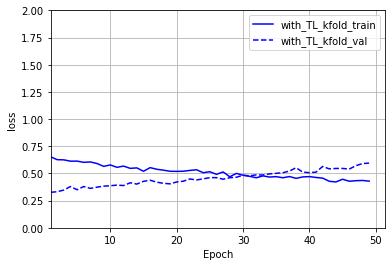

In [114]:
#Plot the model loss metric
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

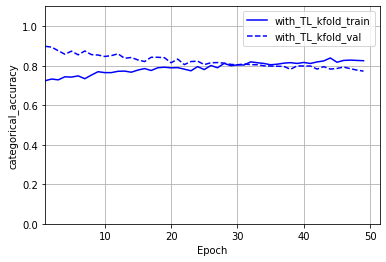

In [115]:
#Plot the model Accuracy metric
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')